# 附加练习作业（选做，折平时分）  seq2seq翻译改进练习

# 导入库

In [1]:
#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(0,1024)

Thu Jun  1 22:51:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 53%   56C    P2   192W / 350W |  12439MiB / 24268MiB |     47%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 65%   

In [2]:
import tensorflow as tf
import re
from tensorflow import keras
from tensorflow.keras.layers import Input,LSTM,Dense,GRU,Embedding
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np

In [3]:
N_UNITS = 256
BATCH_SIZE = 64
EPOCH = 50
NUM_SAMPLES = 21000
embedding_dim = 256

# 数据处理

In [4]:
data_path = 'data/cmn.txt'

In [5]:
df = pd.read_table(data_path,header=None).iloc[:NUM_SAMPLES,:2,]

In [6]:
df.tail()

,0,1
20995,I listen to the radio after dinner.,晚饭后我听收音机。
20996,I live in an apartment in the city.,我住在城市中的一間公寓裡。
20997,I look forward to hearing from you.,我期待收到你的來信。
20998,I look forward to seeing you again.,我期待著再次見到你。
20999,I lost my ticket. What should I do?,我丢了我的票。我該怎麼辦？


In [7]:
df.columns=['inputs','targets']
df['targets'] = df['targets'].apply(lambda x: '\t'+x+'\n')
df.head()

,inputs,targets
0,Hi.,\t嗨。\n
1,Hi.,\t你好。\n
2,Run.,\t你用跑的。\n
3,Stop!,\t住手！\n
4,Wait!,\t等等！\n


In [8]:
input_texts = df.inputs.values.tolist()
target_texts = df.targets.values.tolist()

In [9]:
# 预处理英文句子
def preprocess_sentence(w):
    """处理英文句子
        1,符号左右加空格;
        2,将非字母和非标点符号的字符替换为空格;
        3,空格去重;
    """
    # 符号左右加空格
    w = re.sub(r"([^\w\s])", r" \1 ", w)
    # 将非字母和非标点符号的字符替换为空格
    w = re.sub(r"[^a-zA-Z\s]", " ", w)
    # 空格去重
    w = re.sub(r"\s+", " ", w)
    
    return w

input_texts=[ preprocess_sentence(t) for t in input_texts]

In [10]:
# 4,加载数据;使用tokenizer做词嵌入;分割数据为train,vaild,test数据集
def max_length(tensor):
    """找到数据集中padding的最大值"""
    return max(len(t) for t in tensor)

def tokenize(lang, china = False):
    """将数据集做padding"""
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level = china)
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

## 向量化

In [11]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)

In [12]:
target_tensor, targ_lang_tokenizer = tokenize(target_texts, china=True)
max_length_targ= max_length(target_tensor)
max_length_targ

22

In [13]:
#PADDING字符占用一个码，需要+1
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

In [14]:
max_length_inp =  max_length(input_tensor)
max_length_inp

10

In [15]:
# 6,测试数据转化结果 
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print ("%d ----> %s" % (t, lang.index_word[t]))
            
print("Input Language; index to word mapping")
convert(inp_lang_tokenizer, input_tensor[-1])

Input Language; index to word mapping
1 ----> i
170 ----> lost
12 ----> my
666 ----> ticket
21 ----> what
75 ----> should
1 ----> i
13 ----> do


In [16]:
print("Target Language; index to word mapping")
convert(targ_lang_tokenizer, target_tensor[-1])

Target Language; index to word mapping
1 ----> 	
4 ----> 我
673 ----> 丢
7 ----> 了
4 ----> 我
5 ----> 的
437 ----> 票
3 ----> 。
4 ----> 我
172 ----> 該
93 ----> 怎
43 ----> 麼
648 ----> 辦
9 ----> ？
2 ----> 



In [17]:
from sklearn.model_selection import train_test_split
# 5,拆分训练集和验证集
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=1000)

# 打印数据集长度 - Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

20000 20000 1000 1000


In [18]:
#decoder的label tensor
output_tensor_train=np.zeros_like(target_tensor_train)
output_tensor_train[:,:-1]=target_tensor_train[:,1:]

output_tensor_val=np.zeros_like(target_tensor_val)
output_tensor_val[:,:-1]=target_tensor_val[:,1:]

In [19]:
input_tensor.shape, target_tensor.shape

((21000, 10), (21000, 22))

# 创建模型（作业要点）

In [20]:
def create_model(n_input,n_output,n_units):
    #训练阶段
    #encoder
    encoder_input = Input(shape = (None, ))
    embeddin = Embedding(n_input, embedding_dim)
    #encoder输入维度n_input为每个时间步的输入xt的维度，这里是用来one-hot的英文字符数
    encoder = GRU(n_units, return_state=True)
    #n_units为LSTM单元中每个门的神经元的个数，return_state设为True时才会返回最后时刻的状态h,c
    _,encoder_state = encoder(embeddin(encoder_input))
    encoder_states = [encoder_state]
    #保留下来encoder的末状态作为decoder的初始状态
    
    #decoder
    decoder_input = Input(shape = (None, ))
    embeddout = Embedding(n_output, embedding_dim)
    #decoder的输入维度为中文字符数
    decoder = GRU(n_units,return_sequences=True, return_state=True)
    #训练模型时需要decoder的输出序列来与结果对比优化，故return_sequences也要设为True
    decoder_output, _= decoder(embeddout(decoder_input),initial_state=encoder_states)
    #在训练阶段只需要用到decoder的输出序列，不需要用最终状态h
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_output = decoder_dense(decoder_output)
    #输出序列经过全连接层得到结果
    
    #生成的训练模型
    model = Model([encoder_input,decoder_input], decoder_output)
    #第一个参数为训练模型的输入，包含了encoder和decoder的输入，第二个参数为模型的输出，包含了decoder的输出
    
    #推理阶段，用于预测过程
    #推断模型—encoder
    encoder_infer = Model(encoder_input,encoder_states)
    
    #推断模型-decoder
    decoder_state_input = Input(shape=(n_units,))    
    decoder_states = [decoder_state_input]#上个时刻的状态h 
    
    decoder_infer_output, decoder_infer_states = decoder(embeddout(decoder_input),initial_state=decoder_states)
    decoder_infer_state = [decoder_infer_states]#当前时刻得到的状态
    decoder_infer_output = decoder_dense(decoder_infer_output)#当前时刻的输出
    decoder_infer = Model([decoder_input]+decoder_states,[decoder_infer_output]+decoder_infer_state)
    
    return model, encoder_infer, decoder_infer

In [21]:
model_train, encoder_infer, decoder_infer = create_model(vocab_inp_size, vocab_tar_size, N_UNITS)

In [22]:
#input_tensor, target_tensor

model_train.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

# 模型训练

In [23]:
train_history = model_train.fit([input_tensor_train, target_tensor_train],output_tensor_train,batch_size=BATCH_SIZE,epochs=EPOCH,
                validation_data=([input_tensor_val, target_tensor_val],output_tensor_val) )

Epoch 1/50
313/313 [==============================] - 13s 21ms/step - loss: 2.1455 - accuracy: 0.6697 - val_loss: 1.8055 - val_accuracy: 0.7146
Epoch 2/50
313/313 [==============================] - 5s 17ms/step - loss: 1.6625 - accuracy: 0.7287 - val_loss: 1.6113 - val_accuracy: 0.7371
Epoch 3/50
313/313 [==============================] - 5s 17ms/step - loss: 1.4922 - accuracy: 0.7489 - val_loss: 1.4914 - val_accuracy: 0.7515
Epoch 4/50
313/313 [==============================] - 6s 18ms/step - loss: 1.3712 - accuracy: 0.7637 - val_loss: 1.4044 - val_accuracy: 0.7639
Epoch 5/50
313/313 [==============================] - 6s 18ms/step - loss: 1.2722 - accuracy: 0.7773 - val_loss: 1.3371 - val_accuracy: 0.7735
Epoch 6/50
313/313 [==============================] - 5s 17ms/step - loss: 1.1864 - accuracy: 0.7893 - val_loss: 1.2812 - val_accuracy: 0.7807
Epoch 7/50
313/313 [==============================] - 4s 13ms/step - loss: 1.1118 - accuracy: 0.7992 - val_loss: 1.2421 - val_accuracy: 0.787

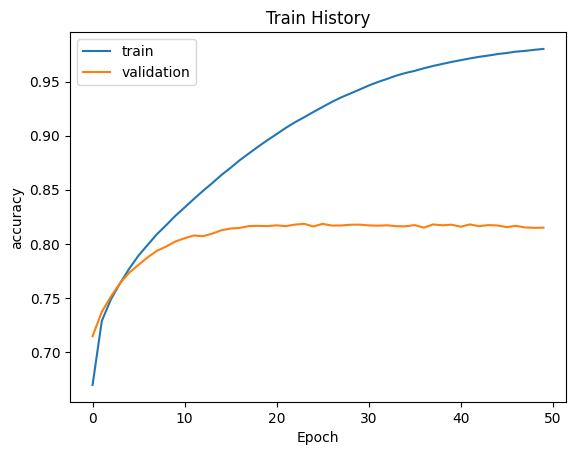

In [24]:
import matplotlib.pyplot as plt
def show_train_his(train_history,train,val):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[val])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.show()
    
show_train_his(train_history,'accuracy','val_accuracy')

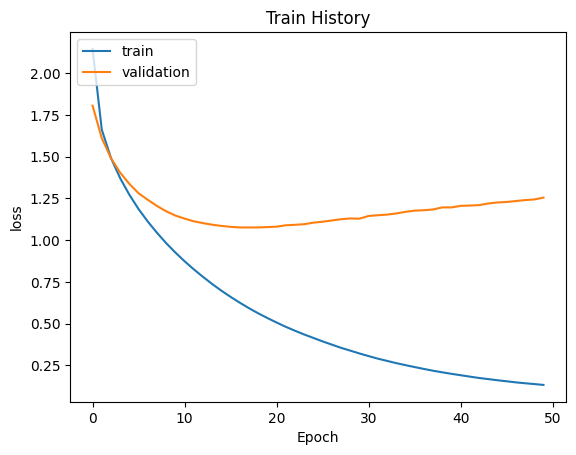

In [25]:
show_train_his(train_history,'loss','val_loss')

# 预测序列

In [26]:
def predict_chinese(source,encoder_inference, decoder_inference, n_steps, features):
    #先通过推理encoder获得预测输入序列的隐状态
    state = encoder_inference.predict(source)
    #第一个字符'\t',为起始标志
    predict_seq = np.zeros((1,1))
    predict_seq[0,0]=1   ##target_dict['\t']

    output = ''
    #开始对encoder获得的隐状态进行推理
    #每次循环用上次预测的字符作为输入来预测下一次的字符，直到预测出了终止符
    for i in range(n_steps):#n_steps为句子最大长度
        #给decoder输入上一个时刻的h,c隐状态，以及上一次的预测字符predict_seq
        yhat,h = decoder_inference.predict([predict_seq,state])
        #注意，这里的yhat为Dense之后输出的结果，因此与h不同
        char_index = np.argmax(yhat[0,-1,:])
        char = targ_lang_tokenizer.index_word[char_index]
        output += char
        state = [h]#本次状态做为下一次的初始状态继续传递
        predict_seq = np.zeros((1,1))
        predict_seq[0,0]=char_index
        if char == '\n':#预测到了终止符则停下来
            break
    return output

In [27]:
def convertinp(tensor):
    s=''
    for t in tensor:
        if t != 0:
            s += inp_lang_tokenizer.index_word[t]+' '
    return s

In [28]:
for i in range(20):
    test = input_tensor_val[i:i+1,:]#i:i+1保持数组是三维
    out = predict_chinese(test,encoder_infer,decoder_infer,max_length_targ,vocab_tar_size)

    print(convertinp(input_tensor_val[i]))
    print(out)

are you able to swim 
你能游泳嗎？

five gallons of regular please 
请用还开着。

i don t have a computer at home 
我沒有她的車子。

don t believe what she says 
不要告诉她是什麼。

this is a beautiful flower 
这是一个小时。

is there a zoo in the park 
公園裡有很多樹嗎?

i m watching tv now 
我在看电视。

i gave tom three cookies 
我汤姆的游答是应该的晚学。

your son is dating my daughter 
你的儿子沒有回喜歡我。

my dream is to become a pilot 
我的計劃是一名演員。

i don t know why they are fighting 
我不知道他們什麼時候會離開。

let me introduce my mother to you 
让我来给你的告。

i feel a whole lot better today 
我今天感觉好多了。

i m getting choked up 
我要出發了。

i forgot to lock the drawer 
我忘了帶長再久。

it s just started raining 
雨在开始的下雨。

i d like to pay by credit card 
我想用支安给它在应该的自家裡用我的花？

don t shoot 
不要动。

i can t think of life without you 
我不能相信你在哪裡。

we studied english 
我們學校中學。

